In [1]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import sys
sys.path
sys.path.append("/Users/lindronics/workspace/4th_year/honours_project/models/classification")

from models import ResNet, AlexNet
from dataset import Dataset

In [2]:
LABELS_PATH = "/Users/lindronics/workspace/4th_year/honours_project_data/main/test.txt"
WEIGHTS_PATH = "/Users/lindronics/workspace/4th_year/out/AlexNet_rgb_weights.h5"

## Load model

In [4]:
data = Dataset(LABELS_PATH, res=(120, 160))

In [4]:
model = AlexNet("rgb", data.num_classes(), data.shape()).get_model()

In [5]:
model.load_weights(WEIGHTS_PATH)

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

## Test prediction

In [7]:
X, y = data[0]
y = np.argmax(y, axis=1)

In [8]:
y_pred = np.argmax(model.predict(X), axis=1)

In [9]:
print(np.vstack([y, y_pred]))

[[3 1 5 3 1 0 1 1 4 5 6 3 1 5 1 7]
 [3 1 5 3 1 0 1 1 4 5 6 3 1 5 1 7]]


## Kernels

In [10]:
layer_dict

{'input_1': <tensorflow.python.keras.engine.input_layer.InputLayer at 0x6340b0950>,
 'tf_op_layer_strided_slice': <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer at 0x1a3d684750>,
 'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x108033190>,
 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x6343bf8d0>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1a3d684f50>,
 'max_pooling2d_1': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x1a3d567e50>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1a3d7a1650>,
 'conv2d_3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1a3d7aacd0>,
 'conv2d_4': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x6343f5110>,
 'max_pooling2d_2': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x1a3d7ceed0>,
 'flatten': <tensorflow.python.keras.layers.core.Flatten at 0x109aa9310>,
 'dense': <tensorflow.python.keras.layers.core.

In [46]:
def plot_kernels(w, padding=1):
    w = (w - np.min(w)) / (np.max(w)-np.min(w))
    
    ksize = w.shape[:2]
    channels = 3 if w.shape[2] == 3 else 1
    filters = w.shape[3]
    
    length = int(np.sqrt(filters))
    
    rows = []
    for i in range(length):
        row = []
        for j in range(length):
            row.append(w[..., :channels, length*i+j])
            row.append(np.ones((ksize[1], padding, channels)))
        row = np.hstack(row)
        rows.append(row)
        rows.append(np.ones((padding, row.shape[1], channels)))
    final = np.vstack(rows)
    final = final[:-padding, :-padding]
    
    if channels == 1:
        final = final[..., 0]
    
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(final, cmap="gray")
    ax.axis('off')

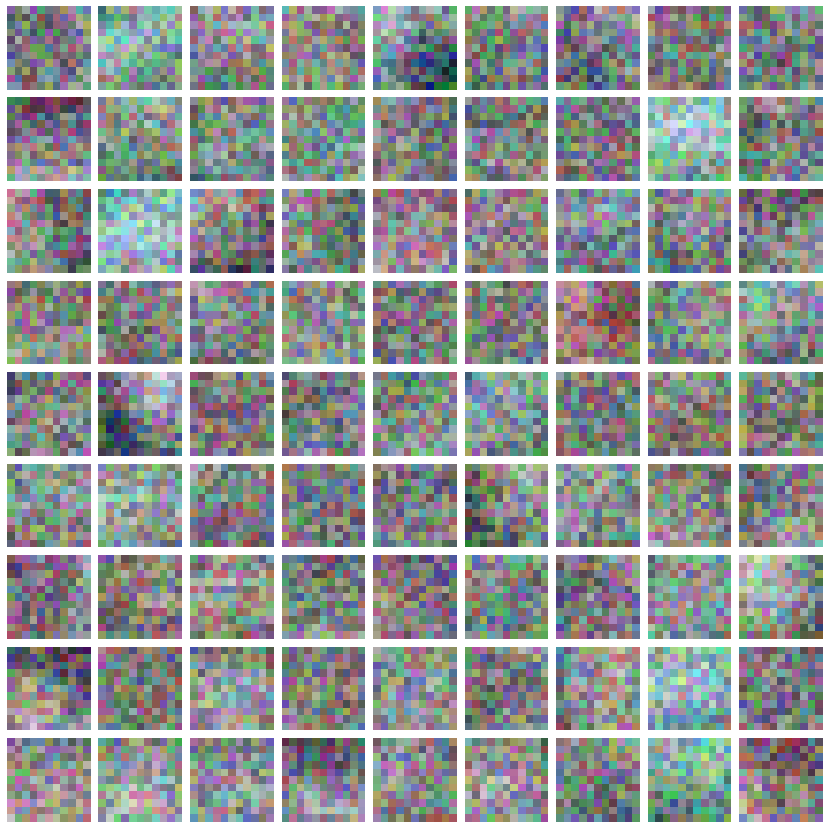

In [51]:
weights = model.get_layer("conv2d").weights[0].numpy()
plot_kernels(weights, padding=1)

## t-SNE class visualisation

In [5]:
WEIGHTS_PATH = "/Users/lindronics/workspace/4th_year/out/ResNet_rgb_weights.h5"
model = ResNet("rgb", data.num_classes(), data.shape()).get_model()
model.load_weights(WEIGHTS_PATH)
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [12]:
layer_dict

{'input_1': <tensorflow.python.keras.engine.input_layer.InputLayer at 0x1a484445d0>,
 'tf_op_layer_strided_slice': <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer at 0x1a48477450>,
 'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1127aa8d0>,
 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x1a48444f90>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1a4855b6d0>,
 'batch_normalization': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x1a40702f50>,
 're_lu': <tensorflow.python.keras.layers.advanced_activations.ReLU at 0x1a4859ecd0>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1a4859e310>,
 'batch_normalization_1': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x1a48648e90>,
 'add': <tensorflow.python.keras.layers.merge.Add at 0x1a4866bb50>,
 're_lu_1': <tensorflow.python.keras.layers.advanced_activations.ReLU at 0x1a4867e450>,
 'co

In [21]:
def get_layer_output(model, layer, x):
    fn = K.backend.function([model.layers[0].input],
                            [layer_dict[layer].output])
    return fn([x])[0]

def plot_embedding(x, y):
    _, ax = plt.subplots(1, figsize=(7, 7))
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    cm = plt.cm.get_cmap("Set1")
    f = plt.figure(figsize=(13, 13))
    for cname, clabel in data.classes.items():  
        x_0 = x[:, 0][y == clabel]
        x_1 = x[:, 1][y == clabel]
        y_class = y[y == clabel]
        sc = ax.scatter(x_0, x_1, lw=0, s=50, cmap=cm, label=cname, alpha=0.7)
    ax.axis("off")
    ax.axis("tight")
    ax.legend()
    
def evaluate_layer(model, layer, X_, y_):
    X_conv = get_layer_output(model, layer, X_)
    y_embeddings = TSNE(n_components=2, init="pca", random_state=0).fit_transform(X_conv.reshape(X_conv.shape[0], -1))
    plot_embedding(y_embeddings, np.argmax(y_, axis=1))

In [7]:
X, y = data.get_all()

In [25]:
%%time
y_embeddings = TSNE(n_components=2, init="pca", random_state=0).fit_transform(X.reshape(X.shape[0], -1))

CPU times: user 37.4 s, sys: 331 ms, total: 37.8 s
Wall time: 35 s


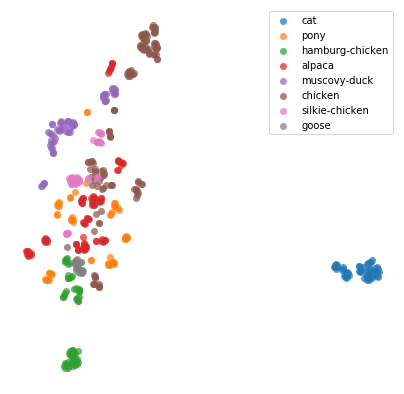

<Figure size 936x936 with 0 Axes>

In [26]:
plot_embedding(y_embeddings, np.argmax(y, axis=1))

CPU times: user 1min 5s, sys: 1.11 s, total: 1min 6s
Wall time: 1min


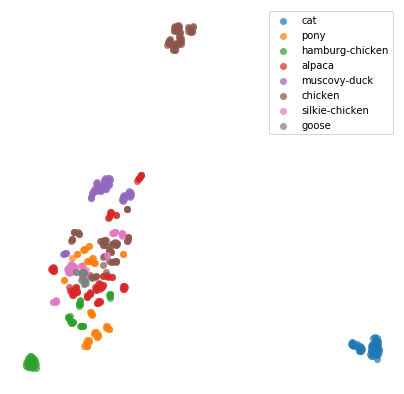

<Figure size 936x936 with 0 Axes>

In [22]:
%%time
evaluate_layer(model, "conv2d", X, y)

CPU times: user 14.4 s, sys: 1.28 s, total: 15.7 s
Wall time: 4.13 s


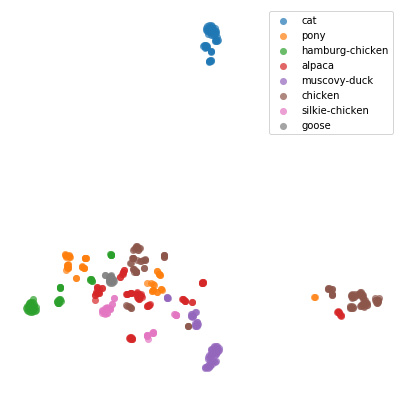

<Figure size 936x936 with 0 Axes>

In [23]:
%%time
evaluate_layer(model, "conv2d_8", X, y)

CPU times: user 15.4 s, sys: 1.34 s, total: 16.7 s
Wall time: 4.56 s


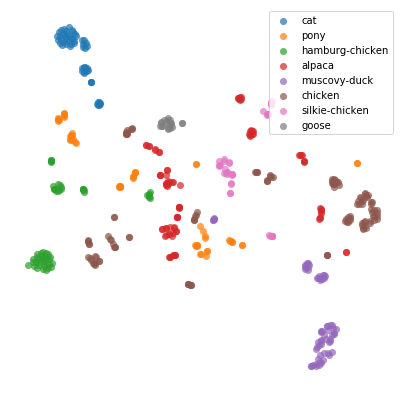

<Figure size 936x936 with 0 Axes>

In [24]:
%%time
evaluate_layer(model, "conv2d_13", X, y)